In [1]:
# import library
import numpy as np 
import pandas as pd
import re
import os

import matplotlib.pyplot as plt
%matplotlib inline

import keras
import keras.utils
from sklearn import preprocessing
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import plot_model
from functools import partial
from keras import metrics

In [2]:
MAX_SEQUENCES_LENGTH = 50 # Maximum kata pada kalimat
MAX_NB_WORDS = 6000 # Vocabulary size
EMBEDDING_DIM = 50 # Dimensions of Glove word vector kadang bisa juga 100

In [3]:
# open dataset,save on dataframe
df = pd.read_csv("dataset/dataset_manual.csv",encoding="ISO-8859-1")

# membuka data slang (data yang akan dibenarkan)
with open('slang.txt') as file:
    slang_map = dict(map(str.strip, line.partition('\t')[::2])
    for line in file if line.strip())
    
df.head()

,created_at,screen_name,text,label
0,5/1/2021 16:48,theoholan,itu konflik rebutan tanah,0
1,5/3/2021 14:12,KoloElang,Bisa tidak? Palestina taat secara kaffah dlm ...,0
2,5/5/2021 10:27,ambiszen,kalau palestina rohingya lebih ke konflik poli...,1
3,5/5/2021 10:54,NephiLaxmus,Teroris 'islam' Itu gejala baru terutama seba...,1
4,5/5/2021 19:57,Atheo8ID,@mataglo @Sentjoko paling sedikit gregetan gu...,2


In [4]:
# drop column created_at and screen_name
df = df.drop(['created_at', 'screen_name'], axis=1)

In [5]:
# Pre-Processing dataset
# fungsi case folding dan menghapus RT dan CC
def casefoldingRemoveRt(text):
     # menghapus RT (reetwet)
    text = re.sub(r'^[RT]+', '', text) 
    # case folding (menjadi lower case)
    text = text.lower()
    # menghapus CC (carbon copy)
    text = re.sub(r'^[cc]+', '', text)
    return text

# fungsi untuk menghapus noise
def removeNoise(text): 
    # menghapus unicode
    text = re.sub(r'(\\u[0-9A-Fa-f]+)','', text)
    # menghapus emoticon
    text = re.sub(r'[^\x00-\x7f]','',text)
    # menghapus url
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',text) 
    # menghapus # (biasanya utk menandai topik tertentu)
    text = re.sub(r'#([^\s]+)', '', text) 
    # menghapus "@users"
    text = re.sub('@[^\s]+','',text)
    return text

# mengganti kata2 slang menjadi lebih baku
slang_words = sorted(slang_map, key=len, reverse=True) # longest first for regex
regex = re.compile(r"\b({})\b".format("|".join(map(re.escape, slang_words))))
replaceSlang = partial(regex.sub, lambda m: slang_map[m.group(1)])

def removePunctuation(text): 
    # menghapus integers/numbers
    text = ''.join([i for i in text if not i.isdigit()]) 
    # khusus untuk tanda baca ' (dirapatkan dengan text)
    text = re.sub("'",'',text)
    # menghapus punctuation (tanda baca)
    text = re.sub(r"[^A-Za-z]+"," ",text)
    # menghapus 1 karakter
    text = re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', text)
    # menghapus whitespace
    text = ' '.join(text.split())
    return text

In [6]:
df['text'] = df['text'].apply(lambda x: casefoldingRemoveRt(x))
df['text'] = df['text'].apply(lambda x: removeNoise(x))
df['text'] = df['text'].apply(lambda x: replaceSlang(x))
df['text'] = df['text'].apply(lambda x: removePunctuation(x))

In [7]:
df.head()

,text,label
0,itu konflik rebutan tanah,0
1,bisa tidak palestina taat secara kaffah dalam ...,0
2,kalau palestina rohingya lebih ke konflik poli...,1
3,teroris islam itu gejala baru terutama sebagai...,1
4,paling sedikit gregetan saya turun karena kamu...,2


In [8]:
#Tokenizing
from nltk.tokenize import word_tokenize 

In [13]:
# Lakukan tokenizer terlebih dahulu
# stop = pd.read_csv('stopword.txt', sep=" ", header=None)
#def word_tokenize_wrapper(text):
   # return word_tokenize(text)

#df['text'] = df['text'].apply(word_tokenize_wrapper)
#df['text']

In [14]:
# Stop Word
#from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
#factory = StopWordRemoverFactory()
#stopword = factory.create_stop_word_remover()

In [15]:
#def stopWord(text):
#stop = stopword.remove(text)
#return stop

#df['text'] = df['text'].apply(lambda x: stopWord(x))
#df['text']

In [16]:
# Stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [17]:
def stemming(text):
    stream = stemmer.stem(text)
    return stream

df['text'] = df['text'].apply(lambda x: stemming(x))
df['text']

0                                 itu konflik rebut tanah
1       bisa tidak palestina taat cara kaffah dalam is...
2       kalau palestina rohingya lebih ke konflik poli...
3       teroris islam itu gejala baru utama bagai imba...
4       paling sedikit gregetan saya turun karena kamu...
                              ...                        
1417    konflik israel palestina urus mereka sedang ap...
1418    konflik antara israel palestina ini jelas buka...
1419                       target gencat senjata permanen
1420    bukan masalah tidak support palestine atau bag...
1421    terus apa guna gencat senjata kalau kamu bunuh...
Name: text, Length: 1422, dtype: object

In [18]:
# delete missing value 
nan_value = float('NaN')
df.replace('', nan_value, inplace=True)
df.dropna(subset=['text'], inplace=True)

In [19]:
# delete data duplicate
df.drop_duplicates(subset='text', keep = 'first', inplace = True)

1    688
0    370
2    346
Name: label, dtype: int64


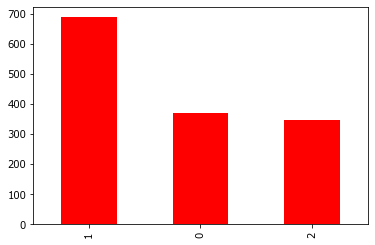

In [20]:
# menghitung Label sentimen (menampilkan tabel pembagian label sentimen)
labels = df.label
labels_count = labels.value_counts()
labels_count.plot(kind="bar", x='Label', y='Jumlah', color='red')
print(labels.value_counts())

In [21]:
# convert to CSV
df.to_csv('just_stemming3.csv', encoding='utf-8', index=False)

In [22]:
# Prepare to X as Feature
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)
sequences = tokenizer.texts_to_sequences(df.text)
# Banyak kata yang telah di tokenizer
word_index = tokenizer.word_index

In [23]:
print('Found %d unique words.' % len(word_index))

Found 2772 unique words.


In [24]:
X = pad_sequences(sequences, maxlen=MAX_SEQUENCES_LENGTH, padding='post')

In [25]:
# Prepare to y as label
y = df["label"]
y = to_categorical(y)

In [26]:
classes = ['0', '1', '2']

In [27]:
# Menyimpan dataset yg sudah di split agar bisa di panggil kembali
#import pickle
#with open('split_dataset/datset70.pickle', 'wb') as f:
#pickle.dump([X_train, X_test, y_train, y_test], f)

In [28]:
# open Glove
print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join('dataset/glove/vectors.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 331286 word vectors.


In [29]:
# Use GloVe as Word Embedding
hits = 0
misses = 0
index = []
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        index.append(word)

In [30]:
test = embeddings_index.get("konflik")
test

array([ 0.084196, -0.017604,  0.428422,  0.043319,  0.223163,  0.869972,
        0.069787,  0.203876, -1.514732, -0.971668, -0.237379,  0.029723,
       -0.965224, -0.394614, -0.478137, -0.56556 , -0.060325, -0.031413,
       -0.255288,  0.420555,  1.289328,  0.992179,  2.252247, -0.294679,
       -0.327707,  1.139334,  0.601816, -0.924584, -0.216141,  0.673712,
       -0.284959, -0.044334,  0.133839,  0.113316,  0.270186, -0.575888,
       -0.364132,  0.845345, -0.008094,  0.746056,  0.378717, -0.066896,
        0.415167, -0.328071, -1.161581, -0.113825,  0.609694, -0.119493,
        1.82021 , -0.085373], dtype=float32)

In [31]:
# jumlah kata yg berhasil di embedding
#hits

In [32]:
# jumlah kata yg miss tidak ada dalam vector glove
#misses

In [33]:
# kata-kataa yang tidak berhasil di bobot
#index

In [34]:
# Embedding layer with glove
embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCES_LENGTH,weights=[embedding_matrix],trainable=True)

In [35]:
# Create Model CNN
# model 2
def create_model():
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
#     model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.3))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(Dropout(0.3))
    model.add(GlobalMaxPooling1D())
#     model.add(Flatten())
    model.add(Dense(32,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [36]:
# Train Model
cnn_model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            138650    
                                                                 
 conv1d (Conv1D)             (None, 50, 128)           19328     
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 128)          0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 25, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 64)            24640     
                                                        

In [37]:
# Split Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20, stratify=y)

In [38]:
cnn_history = cnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
40/40 [==============================] - 2s 20ms/step - loss: 1.1201 - accuracy: 0.4529 - val_loss: 1.0749 - val_accuracy: 0.4965
Epoch 2/10
40/40 [==============================] - 1s 15ms/step - loss: 1.0403 - accuracy: 0.4956 - val_loss: 1.0279 - val_accuracy: 0.4894
Epoch 3/10
40/40 [==============================] - 1s 14ms/step - loss: 1.0318 - accuracy: 0.4901 - val_loss: 1.0679 - val_accuracy: 0.4894
Epoch 4/10
40/40 [==============================] - 1s 14ms/step - loss: 1.0120 - accuracy: 0.5131 - val_loss: 0.9956 - val_accuracy: 0.4965
Epoch 5/10
40/40 [==============================] - 1s 14ms/step - loss: 1.0011 - accuracy: 0.5067 - val_loss: 0.9995 - val_accuracy: 0.5319
Epoch 6/10
40/40 [==============================] - 1s 13ms/step - loss: 0.9794 - accuracy: 0.5115 - val_loss: 1.0071 - val_accuracy: 0.5461
Epoch 7/10
40/40 [==============================] - 1s 14ms/step - loss: 0.9491 - accuracy: 0.5503 - val_loss: 1.0004 - val_accuracy: 0.5603
Epoch 8/10
40

CNN Accuracy: 0.6312056737588653


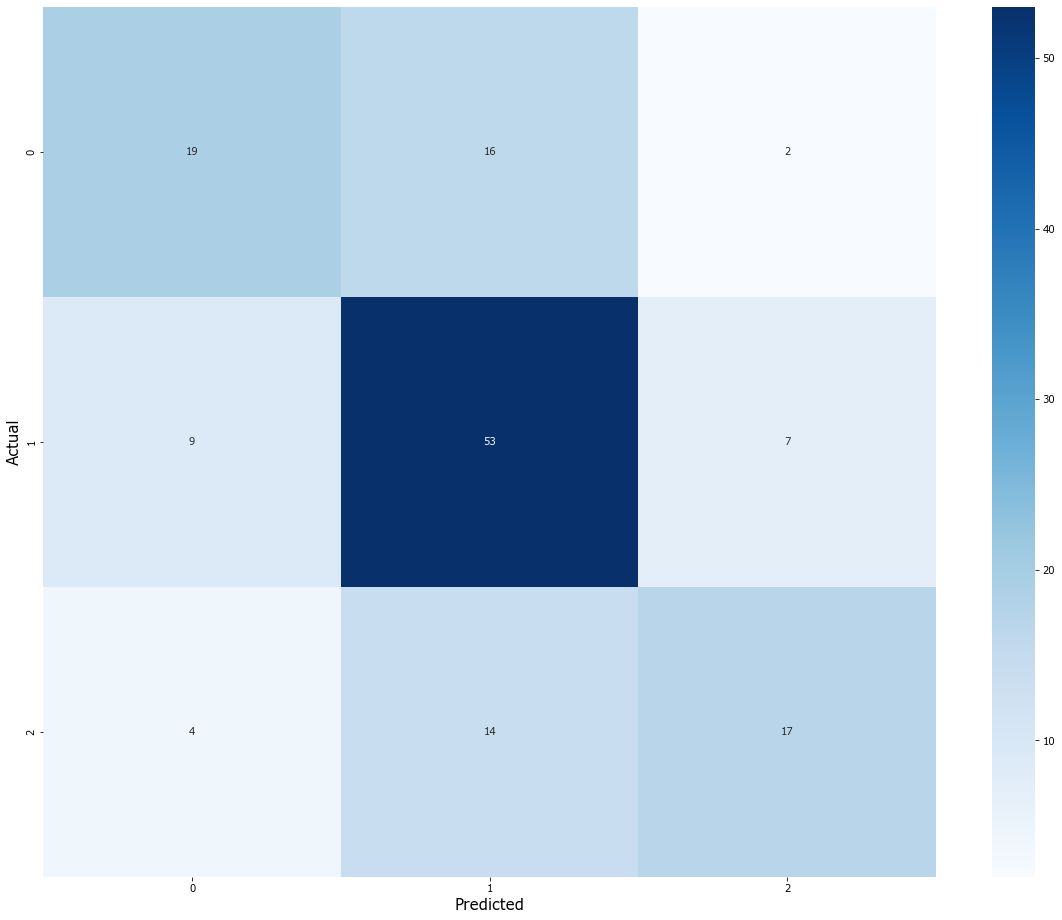

In [39]:
# confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
ypred = cnn_model.predict(X_test)
cnn_accuracy = accuracy_score(y_test.argmax(axis=-1),ypred.argmax(axis=-1))
print("CNN Accuracy:",cnn_accuracy)
cnn_cn = confusion_matrix(y_test.argmax(axis=-1),ypred.argmax(axis=-1))
plt.subplots(figsize=(20,16))
sns.heatmap(cnn_cn,annot=True,fmt="1d",cmap="Blues",cbar=True,xticklabels=classes,yticklabels=classes)
plt.xlabel("Predicted",fontsize=15)
plt.ylabel("Actual",fontsize=15)
# plt.savefig('model60_e40.png')
plt.show()

In [40]:
cnn_cn

array([[19, 16,  2],
       [ 9, 53,  7],
       [ 4, 14, 17]], dtype=int64)

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=-1), ypred.argmax(axis=-1),target_names= classes))

              precision    recall  f1-score   support

           0       0.59      0.51      0.55        37
           1       0.64      0.77      0.70        69
           2       0.65      0.49      0.56        35

    accuracy                           0.63       141
   macro avg       0.63      0.59      0.60       141
weighted avg       0.63      0.63      0.62       141



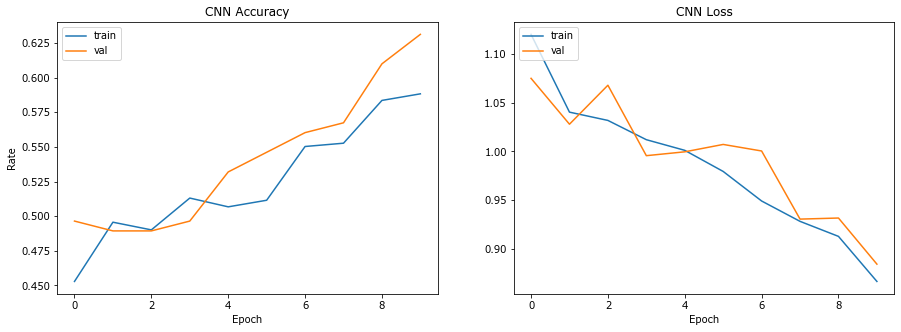

In [42]:
fig3, axe1 = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axe1[0].plot(cnn_history.history["accuracy"],label="accuracy")
axe1[0].plot(cnn_history.history["val_accuracy"],label="accuracy")
axe1[0].legend(['train', 'val'], loc='upper left')
axe1[1].plot(cnn_history.history["loss"],label="loss")
axe1[1].plot(cnn_history.history["val_loss"],label="loss")
axe1[1].legend(['train', 'val'], loc='upper left')
axe1[0].title.set_text("CNN Accuracy")
axe1[1].title.set_text("CNN Loss")
axe1[0].set_xlabel("Epoch")
axe1[1].set_xlabel("Epoch")
axe1[0].set_ylabel("Rate")
plt.show()

In [43]:
# word cloud